# mlreflect usage example

In [1]:
%load_ext autoreload

In [49]:
import matplotlib.pyplot as plt
import numpy as np

import mlreflect

from mlreflect import ReflectivityGenerator, InputPreprocessor, OutputPreprocessor, Prediction, Layer, MultilayerStructure
from mlreflect import h5_tools
from mlreflect.models.simple_model import SimpleModel
from mlreflect.models.model_helpers import create_save_directory

print('Tested with mlreflect version: ' + mlreflect.__version__)

Tested with mlreflect version: 0.13.0


### Load experimental data
In this case DIP_303K.txt contains columns of reflectivity data with the first column containing the q-values in units 1/A

In [3]:
experiment = np.loadtxt('DIP_303K.txt')

In [4]:
q = experiment[9:, 0] # Extract q-values
experimental_reflectivity = experiment[9:, 1:].T

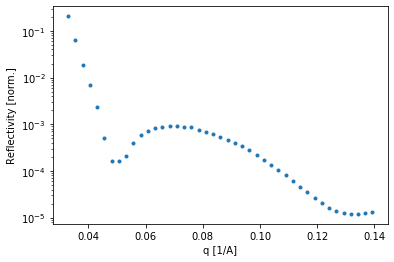

In [5]:
plt.semilogy(q, experimental_reflectivity[30, :], '.')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Generate random training data
Choose parameter ranges for the randomly generated training data with mininimum and maximum values for each layer using Layer objects.

In [6]:
layer1 = Layer('Si', (None, None), (1, 1), (20.1, 20.1))
layer2 = Layer('SiOx', (2.8, 30), (2.5, 2.5), (17.8, 17.8))
layer3 = Layer('Film', (20, 300), (0, 60), (1, 14))

The layers are then added to a MultilayerStructure

In [7]:
sample = MultilayerStructure(ambient_sld_range=(0, 0)) # Initialize MultilayerStructure object with ambient SLD of 0 (air for X-ray)
sample.add_layer(layer1)
sample.add_layer(layer2)
sample.add_layer(layer3)

In [8]:
print(sample)

ambient_sld: 0  -- 0 [1e-6 1/Å^2]
[2] Film:
	thickness: 20 -- 300 [Å]
	roughness: 0 -- 60 [Å]
	sld: 1 -- 14 [1e-6 1/Å^2]
[1] SiOx:
	thickness: 2.8 -- 30 [Å]
	roughness: 2.5 -- 2.5 [Å]
	sld: 17.8 -- 17.8 [1e-6 1/Å^2]
[0] Si:
	thickness: None -- None [Å]
	roughness: 1 -- 1 [Å]
	sld: 20.1 -- 20.1 [1e-6 1/Å^2]



In [9]:
gen = ReflectivityGenerator(q, sample, random_seed=10) # Initialize ReflectivityGenerator using the previously constructed sample
random_labels = gen.generate_random_labels(22500)

Finished 'generate_random_labels' in 0.2108 secs


In [10]:
random_labels.head() # Quick inspection if the generated parameters are as expected

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,1.0,23.202419,209.540101,1.0,2.5,51.631668,20.1,17.8,4.008062,0.0
1,1.0,25.839511,54.341188,1.0,2.5,2.688261,20.1,17.8,6.093867,0.0
2,1.0,15.087188,75.050235,1.0,2.5,35.403232,20.1,17.8,5.066727,0.0
3,1.0,27.549611,176.881459,1.0,2.5,8.746996,20.1,17.8,3.026910,0.0
4,1.0,24.899323,201.752770,1.0,2.5,1.852595,20.1,17.8,3.623453,0.0


In [11]:
random_reflectivity = gen.simulate_reflectivity(random_labels) # Simulate reflectivity using the generated parameters

100%|█████████████████████████████████████████████████████████████████████████| 22500/22500 [00:01<00:00, 16075.56it/s]

Finished 'simulate_reflectivity' in 1.4801 secs


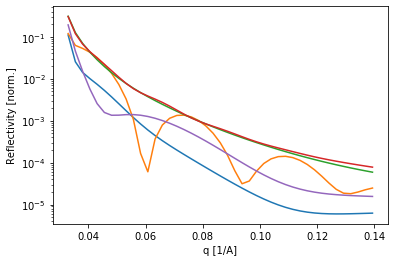

In [12]:
for i in range(5):
    plt.semilogy(q, random_reflectivity[10+i, :])
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

In [13]:
sld_profiles = gen.simulate_sld_profiles(random_labels[0:5]) # Simulate SLD profile for visual inspection

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2517.89it/s]

Finished 'simulate_sld_profiles' in 0.0043 secs


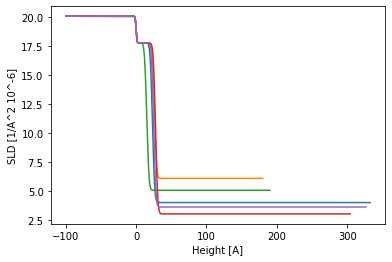

In [14]:
for i in range(5):
    plt.plot(sld_profiles[i][0, :], sld_profiles[i][1, :])
plt.xlabel('Height [A]')
plt.ylabel('SLD [1/A^2 10^-6]')
plt.show()

Write data to an h5 file so it can be reused later.

Split labels and reflectivity into training, validation and testing sets. Since labels are saved as a pandas DataFrame, the index must be dropped.

In [15]:
create_save_directory('output/')
h5_tools.save_data_as_h5('output/saved_training_data.h5', q, random_reflectivity, random_labels, number_of_layers=3)

In [16]:
# loaded_data = h5_tools.read_from_h5('output/saved_training_data.h5') # Data can be loaded like this

In [17]:
train_labels = random_labels[:20000].reset_index(drop=True)
val_labels = random_labels[20000:22000].reset_index(drop=True)
test_labels = random_labels[22000:].reset_index(drop=True)

In [18]:
train_reflectivity = random_reflectivity[:20000, :]
val_reflectivity = random_reflectivity[20000:22000, :]
test_reflectivity = random_reflectivity[22000:, :]

### Train neural network

Apply preprocessing to the input data.

In [19]:
ip = InputPreprocessor()

In [20]:
train_reflectivity_pp = ip.standardize(train_reflectivity)
val_reflectivity_pp = ip.standardize(val_reflectivity)
test_reflectivity_pp = ip.standardize(test_reflectivity)

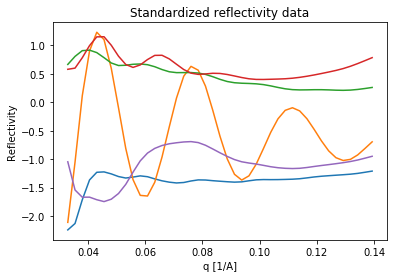

In [21]:
for i in range(5):
    plt.plot(q, train_reflectivity_pp[10+i, :])
plt.title('Standardized reflectivity data')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity')
plt.show()

Initialize OutputPreprocessor object with the predefined sample and apply preprocessing to the labels.

In [22]:
op = OutputPreprocessor(sample, normalization='absolute_max')

train_labels_pp, removed_train_labels = op.apply_preprocessing(train_labels)
val_labels_pp, removed_val_labels = op.apply_preprocessing(val_labels)
test_labels_pp, removed_test_labels = op.apply_preprocessing(test_labels)

In [23]:
train_labels_pp.head()

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.773414,0.698467,0.860528,0.286290
1,0.861317,0.181137,0.044804,0.435276
2,0.502906,0.250167,0.590054,0.361909
3,0.918320,0.589605,0.145783,0.216208
4,0.829977,0.672509,0.030877,0.258818


Train the neural network using the model defined in SimpleModel and save results in 'output/simple_model/'.

In [24]:
import os

In [25]:
path = os.path.join('output', 'simple_model')

In [26]:
simple_model = SimpleModel(path, train_reflectivity_pp.shape[1], train_labels_pp.shape[1])
hist, timestamp = simple_model.train(train_reflectivity_pp, train_labels_pp, val_reflectivity_pp, val_labels_pp)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               17600     
_________________________________________________________________
activation (Activation)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               320800    
_________________________________________________________________
activation_1 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
____

Epoch 23/60
18944/20000 [===========================>..] - ETA: 0s - loss: 0.0030
Epoch 00023: val_loss did not improve from 0.00283
20000/20000 [==============================] - 0s 15us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 24/60
19456/20000 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00024: val_loss did not improve from 0.00283
20000/20000 [==============================] - 0s 14us/sample - loss: 0.0025 - val_loss: 0.0034
Epoch 25/60
16128/20000 [=======================>......] - ETA: 0s - loss: 0.0025
Epoch 00025: val_loss improved from 0.00283 to 0.00255, saving model to output\simple_model\models\2020-04-17-101508.h5
20000/20000 [==============================] - 0s 17us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 26/60
16640/20000 [=======================>......] - ETA: 0s - loss: 0.0024
Epoch 00026: val_loss did not improve from 0.00255
20000/20000 [==============================] - 0s 13us/sample - loss: 0.0024 - val_loss: 0.0031
Epoch 27/60
168

Epoch 56/60
16128/20000 [=======================>......] - ETA: 0s - loss: 8.7955e-04
Epoch 00056: val_loss did not improve from 0.00135
20000/20000 [==============================] - 0s 14us/sample - loss: 8.9301e-04 - val_loss: 0.0014
Epoch 57/60
16896/20000 [========================>.....] - ETA: 0s - loss: 9.0281e-04
Epoch 00057: val_loss did not improve from 0.00135
20000/20000 [==============================] - 0s 13us/sample - loss: 9.2020e-04 - val_loss: 0.0014
Epoch 58/60
16640/20000 [=======================>......] - ETA: 0s - loss: 0.0010    
Epoch 00058: val_loss did not improve from 0.00135
20000/20000 [==============================] - 0s 13us/sample - loss: 0.0010 - val_loss: 0.0017
Epoch 59/60
19968/20000 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00059: val_loss did not improve from 0.00135
20000/20000 [==============================] - 0s 14us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 60/60
16640/20000 [=======================>......] - ETA: 

Inspect training and validation loss.

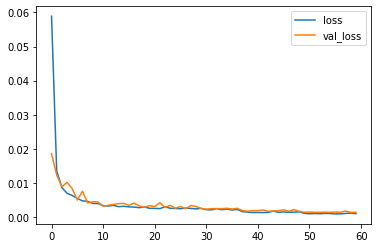

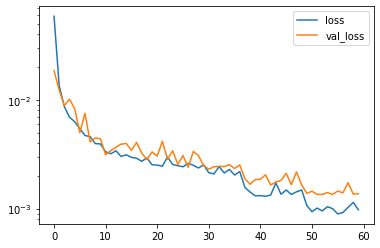

In [27]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Test on simulated data

Initialize the Prediction object for the given model and labels.

In [28]:
pr = Prediction('output/simple_model/models/' + timestamp + '.h5', op.used_label_names)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
pred_test_labels = pr.predict_labels(test_reflectivity_pp) # Predict labels for simulated test data

Finished 'predict_labels' in 0.0625 secs


In [30]:
test_labels_pp # Inspect previously generated and preprocessed test labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.104310,0.160684,0.041288,0.148998
1,0.676212,0.536493,0.435527,0.541172
2,0.671920,0.666251,0.091792,0.473413
3,0.123971,0.421352,0.505908,0.123976
4,0.202816,0.458623,0.173592,0.139399
...,...,...,...,...
495,0.410248,0.408922,0.678146,0.929775
496,0.930943,0.973662,0.639436,0.072726
497,0.194831,0.683757,0.786365,0.469889
498,0.694246,0.304790,0.628851,0.998213


In [31]:
pred_test_labels # Inspect predicted test labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.139908,0.170447,0.036874,0.129362
1,0.681065,0.530134,0.440287,0.545129
2,0.662015,0.664832,0.095344,0.468128
3,0.129863,0.417456,0.512588,0.133763
4,0.190928,0.465288,0.167626,0.145763
...,...,...,...,...
495,0.418748,0.415838,0.674878,0.929540
496,0.934049,1.001588,0.669080,0.076522
497,0.194917,0.694922,0.794909,0.474822
498,0.717557,0.307594,0.628463,1.001855


In [32]:
pred_test_labels.reset_index(drop=True) - test_labels_pp.reset_index(drop=True) # Calculate absolute error

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.035599,0.009763,-0.004414,-0.019636
1,0.004854,-0.006359,0.004760,0.003956
2,-0.009905,-0.001419,0.003552,-0.005285
3,0.005892,-0.003896,0.006681,0.009787
4,-0.011888,0.006665,-0.005966,0.006364
...,...,...,...,...
495,0.008500,0.006916,-0.003268,-0.000235
496,0.003106,0.027926,0.029645,0.003796
497,0.000085,0.011164,0.008544,0.004934
498,0.023311,0.002804,-0.000388,0.003642


In [33]:
mae = pr.mean_absolute_error(pred_test_labels, test_labels_pp) # Calculate mean absolute error
print(mae)

SiOx_thickness    0.027863
Film_thickness    0.010616
Film_roughness    0.012727
Film_sld          0.013864
dtype: float64


In [34]:
mape = pr.mean_absolute_percentage_error(pred_test_labels, test_labels_pp) # Calculate mean absolute percentage error
print(mape)

SiOx_thickness    0.103455
Film_thickness    0.029172
Film_roughness    0.277239
Film_sld          0.031739
dtype: float64


In [35]:
test_labels # Inspect previously generated test labels

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,1.0,3.129286,48.205168,1.0,2.5,2.477285,20.1,17.8,2.085978,0.0
1,1.0,20.286347,160.947966,1.0,2.5,26.131638,20.1,17.8,7.576412,0.0
2,1.0,20.157595,199.875328,1.0,2.5,5.507502,20.1,17.8,6.627786,0.0
3,1.0,3.719136,126.405706,1.0,2.5,30.354450,20.1,17.8,1.735668,0.0
4,1.0,6.084486,137.586769,1.0,2.5,10.415530,20.1,17.8,1.951585,0.0
...,...,...,...,...,...,...,...,...,...,...
495,1.0,12.307443,122.676467,1.0,2.5,40.688741,20.1,17.8,13.016849,0.0
496,1.0,27.928275,292.098517,1.0,2.5,38.366131,20.1,17.8,1.018162,0.0
497,1.0,5.844931,205.127245,1.0,2.5,47.181894,20.1,17.8,6.578441,0.0
498,1.0,20.827388,91.436980,1.0,2.5,37.731076,20.1,17.8,13.974978,0.0


In [36]:
restored_pred_test_labels = op.restore_labels(pred_test_labels, removed_test_labels) # Reverse preprocessing on predicted test labels

In [37]:
restored_pred_test_labels # Inspect predicted test labels without preprocessing

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,1.0,4.197247,51.134075,1.0,2.5,2.212419,20.1,17.8,1.811070,0.0
1,1.0,20.431953,159.040176,1.0,2.5,26.417240,20.1,17.8,7.631800,0.0
2,1.0,19.860435,199.449631,1.0,2.5,5.720637,20.1,17.8,6.553794,0.0
3,1.0,3.895899,125.236877,1.0,2.5,30.755306,20.1,17.8,1.872682,0.0
4,1.0,5.727846,139.586411,1.0,2.5,10.057552,20.1,17.8,2.040682,0.0
...,...,...,...,...,...,...,...,...,...,...
495,1.0,12.562447,124.751411,1.0,2.5,40.492683,20.1,17.8,13.013563,0.0
496,1.0,28.021465,300.476318,1.0,2.5,40.144817,20.1,17.8,1.071306,0.0
497,1.0,5.847496,208.476471,1.0,2.5,47.694542,20.1,17.8,6.647513,0.0
498,1.0,21.526718,92.278168,1.0,2.5,37.707771,20.1,17.8,14.025967,0.0


Compare test labels with predicted test labels.

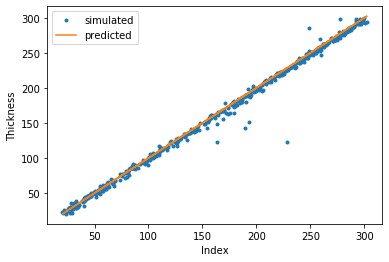

In [38]:
plt.plot(restored_pred_test_labels['Film_thickness'], test_labels['Film_thickness'], '.', label='simulated')
plt.plot(restored_pred_test_labels['Film_thickness'], restored_pred_test_labels['Film_thickness'], label='predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Thickness')
plt.show()

Simulate reflectivity from predicted labels.

In [39]:
pred_test_reflectivity = gen.simulate_reflectivity(restored_pred_test_labels)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 13872.99it/s]

Finished 'simulate_reflectivity' in 0.0401 secs


Plot test reflectivity with predicted reflectivity

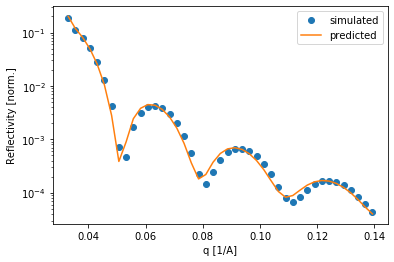

In [40]:
plt.semilogy(q, test_reflectivity[23, :], 'o', label='simulated')
plt.semilogy(q, pred_test_reflectivity[23, :], label='predicted')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Test on experimental data

In [41]:
experimental_reflectivity_pp = ip.standardize(experimental_reflectivity)

In [42]:
pred_experimental_test_labels = pr.predict_labels(experimental_reflectivity_pp) # Predict labels for experimental test data

Finished 'predict_labels' in 0.0043 secs


In [43]:
pred_experimental_test_labels

,SiOx_thickness,Film_thickness,Film_roughness,Film_sld
0,0.648740,0.650461,0.229121,0.089617
1,0.660592,0.641744,0.326816,0.121223
2,0.735440,0.541372,0.297818,0.130652
3,0.690620,0.263229,0.251210,0.180205
4,0.838164,0.232044,0.095354,0.202070
...,...,...,...,...
64,0.295749,0.476172,0.474727,0.831359
65,0.314153,0.479398,0.485031,0.826181
66,0.300891,0.490218,0.497543,0.833900
67,0.334451,0.502857,0.497170,0.832833


In [44]:
restored_pred_experimental_test_labels = op.restore_labels(pred_experimental_test_labels, removed_test_labels) # Reverse preprocessing on predicted test labels

In [45]:
restored_pred_experimental_test_labels

,Si_thickness,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,ambient_sld
0,1.0,19.462202,195.138382,1.0,2.5,13.747282,20.1,17.8,1.254631,0.0
1,1.0,19.817755,192.523239,1.0,2.5,19.608948,20.1,17.8,1.697127,0.0
2,1.0,22.063200,162.411713,1.0,2.5,17.869095,20.1,17.8,1.829133,0.0
3,1.0,20.718594,78.968567,1.0,2.5,15.072598,20.1,17.8,2.522864,0.0
4,1.0,25.144913,69.613098,1.0,2.5,5.721231,20.1,17.8,2.828986,0.0
...,...,...,...,...,...,...,...,...,...,...
64,1.0,8.872459,142.851532,1.0,2.5,28.483641,20.1,17.8,11.639030,0.0
65,1.0,9.424582,143.819321,1.0,2.5,29.101860,20.1,17.8,11.566535,0.0
66,1.0,9.026721,147.065292,1.0,2.5,29.852591,20.1,17.8,11.674604,0.0
67,1.0,10.033525,150.857162,1.0,2.5,29.830219,20.1,17.8,11.659656,0.0


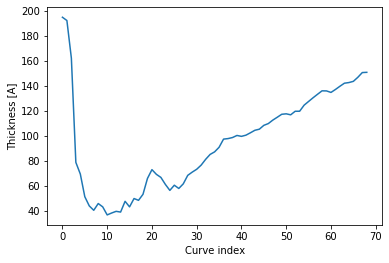

In [46]:
plt.plot(restored_pred_experimental_test_labels['Film_thickness'])
plt.xlabel('Curve index')
plt.ylabel('Thickness [A]')
plt.show()

In [47]:
pred_experimental_reflectivity = gen.simulate_reflectivity(restored_pred_experimental_test_labels)

100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 9849.47it/s]

Finished 'simulate_reflectivity' in 0.0106 secs


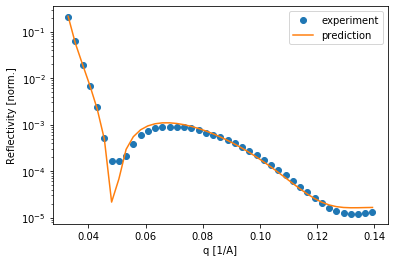

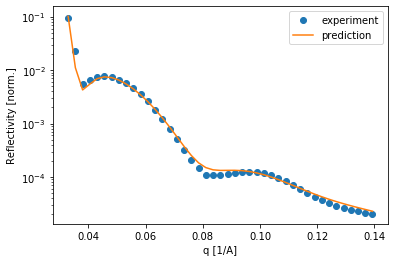

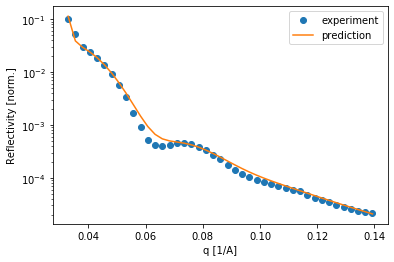

In [48]:
plt.semilogy(q, experimental_reflectivity[30, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[30, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[50, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[50, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

plt.semilogy(q, experimental_reflectivity[-1, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[-1, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()